In [15]:
from data_cleaning import clean_dataframe, append_msrp, append_retains_value, get_expected_value
import pandas as pd
import numpy as np

# from sklearnex import patch_sklearn
# patch_sklearn()

In [16]:
try:
    # df = pd.read_csv("true_car_cleaned.csv", index_col=0)
    df = pd.read_csv("true_car_cleaned2.csv", index_col=0)
except FileNotFoundError:
    df = pd.read_csv("true_car_listings.csv")
    df = clean_dataframe(df)
    df = append_msrp(df)
    df = append_retains_value(df)
    df = df.dropna()

In [17]:
# # cleaned data doesn't have this currently
# df['expected_value'] = get_expected_value(df, last_year=2017, method='experian')
# df = append_retains_value(df)

In [18]:
# # Subsample dataset for initial testing
# df = df.sample(100000)

In [19]:
print(df.columns)

Index(['Price', 'Year', 'Mileage', 'City', 'State', 'Vin', 'Make', 'Model',
       'MSRP', 'expected_value', 'retains_value'],
      dtype='object')


In [20]:
# Correlation Matrix
# corr = df.corr()
# corr.style.background_gradient(cmap='coolwarm')

We see the variable that will eventually become our class, `retains_value`, has very little correlation to `MSRP` and `Mileage`. This may suggest more of a connection between Make, Model, and specific model-years (since they aren't featured in this numerical-only matrix).

`expected_value` is strongly correlated to `Price`, meaning on average our metric of depreciation mostly holds true. However, with this machine learning model we hope to further granularize this and give a better understanding of how different features affect how value is held (or not held).

In [21]:
# df.hist(['Price', 'expected_value'])

In [22]:
# we should drop `Price`, since our model should neither know it nor predict it
df = df[['Year', 'Mileage', 'Make', 'MSRP', 'retains_value']]
df['retains_value'].value_counts()

True     309529
False    308233
Name: retains_value, dtype: int64

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC, LinearSVC
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn import tree


X = df.drop('retains_value', axis=1)
y = df['retains_value']

numeric_features = ['Year', 'Mileage', 'MSRP']
numeric_transformer = Pipeline(steps=[("scaler", StandardScaler())])

categorical_features = ['Make']
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
])

In [24]:
# clf = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", LinearSVC(verbose=1, dual=False))])
classifier = LinearSVC(verbose=1, dual=False)
classifier = SVC(verbose=1, kernel='linear')
classifier = tree.DecisionTreeClassifier()

clf = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", classifier)])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [25]:
clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Year', 'Mileage', 'MSRP']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Make'])])),
                ('classifier', DecisionTreeClassifier())])

In [26]:
clf.score(X_test, y_test)
# clf.predict(X_test)

0.7276148697320178

In [67]:
plt.figure(dpi=1000)
tree.plot_tree(clf['classifier'], class_names=True)

[Text(0.7421497013272998, 0.9861111111111112, 'X[34] <= 0.5\ngini = 0.5\nsamples = 8000\nvalue = [3973, 4027]\nclass = y[1]'),
 Text(0.4893981916922033, 0.9583333333333334, 'X[1] <= -0.596\ngini = 0.5\nsamples = 7773\nvalue = [3957, 3816]\nclass = y[0]'),
 Text(0.1666328253038787, 0.9305555555555556, 'X[0] <= 0.635\ngini = 0.483\nsamples = 2341\nvalue = [957, 1384]\nclass = y[1]'),
 Text(0.09962939884366749, 0.9027777777777778, 'X[6] <= 0.5\ngini = 0.432\nsamples = 977\nvalue = [308, 669]\nclass = y[1]'),
 Text(0.0643594077210234, 0.875, 'X[2] <= -0.345\ngini = 0.425\nsamples = 953\nvalue = [292, 661]\nclass = y[1]'),
 Text(0.03660315942820723, 0.8472222222222222, 'X[12] <= 0.5\ngini = 0.359\nsamples = 324\nvalue = [76, 248]\nclass = y[1]'),
 Text(0.028919694072657744, 0.8194444444444444, 'X[17] <= 0.5\ngini = 0.318\nsamples = 297\nvalue = [59, 238]\nclass = y[1]'),
 Text(0.019525630519894383, 0.7916666666666666, 'X[8] <= 0.5\ngini = 0.28\nsamples = 256\nvalue = [43, 213]\nclass = y[1]

Error in callback <function flush_figures at 0x000001900B443670> (for post_execute):


KeyboardInterrupt: 

In [44]:
# clf.predict([[2012, 48000, 'Honda', 15755]])
X_test.iloc[0]

Year          2013
Mileage      39322
Make          Ford
MSRP       16200.0
Name: 274636, dtype: object

In [13]:
# mycar = pd.Series({'Year': 2012, 'Mileage': 48000, 'Make': 'Honda', 'MSRP': 15755})
car = pd.DataFrame({'Year': 2012, 'Mileage': 48000, 'Make': 'Honda', 'MSRP': 15755}, index=[0])
clf.predict(car)

array([ True])

In [14]:
import matplotlib.pyplot as plt

In [15]:
pipe = clf
clf = pipe['classifier']
# get the separating hyperplane
w = clf.coef_[0]
a = -w[0] / w[1]
xx = np.linspace(-5, 5)
yy = a * xx - (clf.intercept_[0]) / w[1]


margin = 1 / np.sqrt(np.sum(clf.coef_ ** 2))
yy_down = yy - np.sqrt(1 + a ** 2) * margin
yy_up = yy + np.sqrt(1 + a ** 2) * margin

plt.figure(1, figsize=(4, 3))
plt.clf()
plt.plot(xx, yy, 'k-')
plt.plot(xx, yy_down, 'k--')
plt.plot(xx, yy_up, 'k--')

plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=80,
            facecolors='none', zorder=10, edgecolors='k')
plt.scatter(X[:, 0], X[:, 1], c=Y, zorder=10, cmap=plt.cm.Paired,
            edgecolors='k')

plt.axis('tight')
x_min = -4.8
x_max = 4.2
y_min = -6
y_max = 6

XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
Z = clf.predict(np.c_[XX.ravel(), YY.ravel()])

# Put the result into a color plot
Z = Z.reshape(XX.shape)
plt.figure(1, figsize=(4, 3))
plt.pcolormesh(XX, YY, Z, cmap=plt.cm.Paired)

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

plt.xticks(())
plt.yticks(())

plt.show()

IndexError: row index (1) out of range

In [17]:
clf.support_vectors_

<59x23 sparse matrix of type '<class 'numpy.float64'>'
	with 236 stored elements in Compressed Sparse Row format>

In [60]:
# np.unique(clf.predict(X_test), return_counts=True)
y.value_counts()

True     498933
False    118829
Name: retains_value, dtype: int64

In [62]:
y_test.value_counts()

True     99787
False    23766
Name: retains_value, dtype: int64

In [4]:
df

,Price,Year,Mileage,City,State,Vin,Make,Model,MSRP,expected_value,retains_value
12,7750,2009,91980,San Antonio,TX,JH4CU26639C015787,Acura,TSX,29160.0,7478.42,True
17,14590,2010,19250,Clearwater,FL,JH4CU2F6XAC041680,Acura,TSX,29310.0,8843.40,True
18,9500,2011,68289,Arcadia,FL,JH4CU2F62BC007928,Acura,TSX,29610.0,10510.49,False
19,7990,2007,60552,Fairlawn,NJ,JH4CL96857C019060,Acura,TSX,28090.0,5204.90,True
26,14500,2010,25926,Columbus,OH,JH4CU2F69AC027155,Acura,TSX,29310.0,8843.40,True
...,...,...,...,...,...,...,...,...,...,...,...
852094,54995,2016,16578,Anchorage,AK,YV4A22PL0G1017599,Volvo,XC90,43950.0,35160.00,True
852098,56995,2016,13041,Salem,OR,YV4A22PM4G1051814,Volvo,XC90,43950.0,35160.00,True
852099,56789,2016,19250,Summit,NJ,YV4A22PM8G1050830,Volvo,XC90,43950.0,35160.00,True
852110,57222,2016,15070,Frederick,MD,YV4BC0PK4G1078614,Volvo,XC90,43950.0,35160.00,True


In [65]:
df.hist(['expected_value'])

KeyError: "None of [Index(['expected_value'], dtype='object')] are in the [columns]"

In [ ]:
df[df.isna().any(axis=1)]

In [ ]:
df.dropna()['retains_value'].value_counts()

<AxesSubplot:>

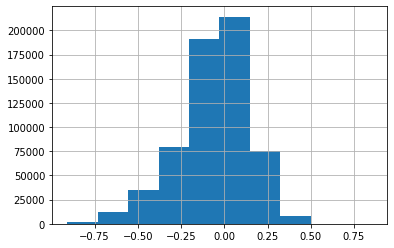

In [10]:
tmp_df = df.copy(deep=True)
tmp_df['expected_value'] = get_expected_value(tmp_df, 201 + 8)
tmp_df.apply(lambda x: (x['Price'] - x['expected_value']) / (x['Price'] + x['expected_value']), axis=1).hist()

<AxesSubplot:>

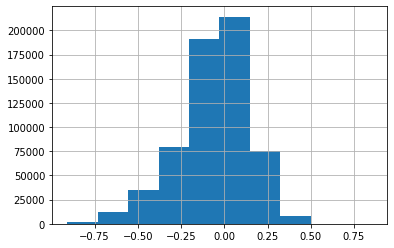

In [11]:
tmp_df = df.copy(deep=True)
tmp_df['expected_value'] = get_expected_value(tmp_df, 201 + 7)
tmp_df.apply(lambda x: (x['Price'] - x['expected_value']) / (x['Price'] + x['expected_value']), axis=1).hist()

In [3]:
for i in range (5, 9):
    print(get_expected_value(df, 201 + i).sum())

12563325022.400002
12563325022.400002
12563325022.400002
12563325022.400002


<AxesSubplot:>

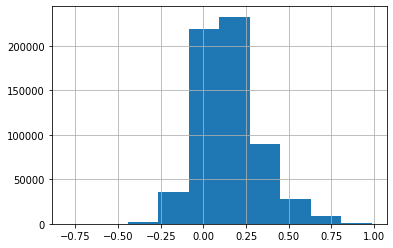

In [6]:
df.dropna().apply(lambda x: (x['Price'] - x['expected_value']) / (x['Price'] + x['expected_value']), axis=1).hist()

In [ ]:
df[df['Make'] == 'Honda']['Model'].unique()

In [ ]:
msrp_df = df[['Year', 'Make', 'Model']]

In [ ]:
print(f"original number of entries: {len(msrp_df)}")

In [ ]:
unique_msrp_df = msrp_df.drop_duplicates()
print(f"unique number of entries: {len(unique_msrp_df)}")

In [ ]:
toyota_models = unique_msrp_df['Model'][unique_msrp_df['Make'] == 'Toyota'].unique()

In [ ]:
unique_msrp_df[unique_msrp_df['Model'] == 'Supra3dr']

In [ ]:
unique_msrp_df['Model'].value_counts()

In [ ]:
# from utilities import upper_count_regex
cleaned = set()
for model in toyota_models:
    if upper_count_regex(model) == 1:
        cleaned.add(model)

In [ ]:
# cleaned
maybe = []
no_split = []
a = set()
b = set()
for model in cleaned:
    dig_idx = get_trailing_digit_index(model)
    if dig_idx < 2:
        print(model)
        maybe.append(model)
        no_split.append(model)
        a.add(model)
    else:
        print(f"{model} -> {model[:dig_idx]}")
        maybe.append(model[:dig_idx])
        b.add(model[:dig_idx])

In [ ]:
toyota_models

In [ ]:
len(cleaned)

In [ ]:
len(maybe)

In [ ]:
len(no_split)

In [ ]:
len(set(maybe))

In [ ]:
np.unique(toyota_models).shape

In [ ]:
print(a - b)
print(b - a)

In [ ]:
# holds_value = used_price > standard_depreciation(msrp, years_old)

In [ ]:
tmp_mdl = df['Model'].apply(parse_model)

In [ ]:
tmp_mdl.value_counts()[:50]

In [ ]:
type(df)

In [ ]:
# cleaned_df = clean_dataframe(df)
cleaned_df['Model'].unique().shape

In [ ]:
tmp_df = df.copy()
tmp_df['Model'] = tmp_df['Model'].apply(parse_model)
tmp_df

In [ ]:
tmp_msrp = append_msrp(tmp_df.sample(100))

In [ ]:
tmp_msrp = tmp_msrp.dropna()

In [ ]:
tmp_msrp['retains_value'] = tmp_msrp.apply(lambda x: retains_value(x['Price'], x['expected_value']), axis=1)
tmp_msrp['retains_value'].value_counts()

In [ ]:
tmp_msrp

In [ ]:
df['City'].unique().shape

In [ ]:
# tmp_msrp['MSRP']

In [ ]:
tmp_sample = tmp_msrp.sample(10)
tmp_sample['MSRP'] = [69 for i in range(10)]

In [ ]:
tmp_merge = pd.merge(tmp_df, tmp_sample, how='left')

In [ ]:
tmp_sample

In [ ]:
tmp_merge.dropna().value_counts(['Make', 'Model'])

In [ ]:
toyota_df = msrp_df[msrp_df['Make'] == 'Toyota'].copy()
toyota_df['Model'] = toyota_df['Model'].apply(parse_model)
unq_toyota_df = toyota_df.drop_duplicates()
# unq_toyota_df['Model'].unique()
toyota_l_d = unq_toyota_df.to_dict(orient='records')

msrp_list = get_msrp_list(toyota_l_d)
print(msrp_list)


In [ ]:
unq_toyota_df['MSRP'] = msrp_list
unq_toyota_df

In [ ]:
index = toyota_df.index
tmp = pd.merge(toyota_df, unq_toyota_df, how='left')
tmp.index = index
tmp

In [ ]:
df

In [ ]:
toyota_df

In [ ]:
all_toyota = msrp_df[msrp_df['Make'] == 'Toyota']['Model']

In [ ]:
all_toyota.to_csv("all_toyota.csv", index=False)